In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.table import Table
from astropy.table import join
import astropy.io.fits as fits
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import speclite
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.recurrent import LSTM
from keras.utils import np_utils

This routine has to be updated with the new DESI format

In [4]:
def readBricks(path_in,brick_name):
    hdus = []
    for channel in 'brz':
        filename = 'brick-{}-{}.fits'.format(channel,brick_name)
        hdulist = fits.open(os.path.join(path_in,filename))
        hdus.append(hdulist)
    return hdus

In [5]:
hdus = readBricks('./fake_qso/','all-osu')

In [6]:
hdus[0][0].shape, hdus[1][0].shape, hdus[2][0].shape

((4000, 4760), (4000, 4232), (4000, 4798))

In [7]:
def downsample(camera,nspec,ndownsample, si=0):
    data = np.ones((nspec,len(hdus[camera][2].data[si:])), dtype=[('flux', float), ('ivar',float)])
    data['flux']=hdus[camera][0].data[:,si:]
    data['ivar']=hdus[camera][1].data[:,si:]
    return speclite.downsample(data,ndownsample,axis=1,weight='ivar')

In [8]:
flux_b = downsample(0,4000,20)
flux_r = downsample(1,4000,23)
flux_z = downsample(2,4000,35,si=3)

In [9]:
print flux_b.shape, flux_r.shape, flux_z.shape

(4000, 238) (4000, 184) (4000, 137)


In [10]:
qso_flux = np.hstack([flux_b,flux_r,flux_z])

In [11]:
qso_flux.shape

(4000, 559)

In [12]:
table_train = Table.read('./fake_qso/training_table_all_0.0.3_z_mag.fits.gz')

In [13]:
tab_nico = Table.read('./fake_qso/rm_brick_osu_0.0.3.fits')

The spectra and the training table have the same ordering

We are going to generate a vector with `1` where the object type is QSO and `0` elsewhere.

In [15]:
table_train

TARGETID,TRUE_OBJTYPE,Z,MAG [5]
int64,str10,float64,float32
359019675454725751,HZQSO,2.80687618256,0.0 .. 0.0
2775006358251495435,ELG,0.0,0.0 .. 0.0
3522945317776209514,STAR,0.0,0.0 .. 0.0
1252617061243456603,HZQSO,2.17549347878,0.0 .. 0.0
3020544656171833094,QSO,2.01650881767,0.0 .. 0.0
1975922397008082299,HZQSO,2.26564359665,0.0 .. 0.0
2438371134459573657,HZQSO,2.89319777489,0.0 .. 0.0
263615315938080723,HZQSO,3.48627591133,0.0 .. 0.0
3280591891290288611,QSO,0.73425835371,0.0 .. 0.0


In [16]:
len(table_train)

1000

In [18]:
hzqso = table_train['TRUE_OBJTYPE']=='HZQSO'
bin1 = np.logical_and(table_train['Z']>=2.1,table_train['Z']<2.6)
bin2 = np.logical_and(table_train['Z']>=2.6,table_train['Z']<3.1)
bin3 = table_train['Z']>=3.1
hzqso_1 = np.logical_and(hzqso,bin1)
hzqso_2 = np.logical_and(hzqso,bin2)
hzqso_3 = np.logical_and(hzqso,bin3)
table_train['TRUE_OBJTYPE'][hzqso_1]='HZ_QSO_1'
table_train['TRUE_OBJTYPE'][hzqso_2]='HZ_QSO_2'
table_train['TRUE_OBJTYPE'][hzqso_3]='HZ_QSO_3'
elgs = table_train['TRUE_OBJTYPE']=='ELG'
table_train['TRUE_OBJTYPE'][elgs]='GALAXY'
encoder = LabelEncoder()
encoder.fit(table_train['TRUE_OBJTYPE'])
encoded_Y = encoder.transform(table_train['TRUE_OBJTYPE'])
dummy_y = np_utils.to_categorical(encoded_Y)

87 79 77
[2 0 5 1 4 1 2 3 4 4 4 5 3 0 0 2 0 4 0 4 5 0 0 0 4 4 0 0 0 0 0 0 4 5 5 1 0
 5 5 1 2 0 3 5 0 2 4 5 5 4 0 0 4 4 4 2 4 5 0 0 5 3 5 5 4 5 0 5 0 5 4 0 4 5
 5 4 0 0 0 4 1 1 4 4 5 0 5 0 4 4 1 3 4 3 3 4 4 1 4 4 4 5 3 0 4 5 2 0 0 5 5
 5 2 0 4 5 4 3 4 5 0 2 4 5 5 0 0 4 1 4 0 2 4 4 4 0 1 0 4 3 4 4 5 0 3 0 4 1
 4 4 4 4 5 5 4 5 0 5 5 5 0 0 0 5 3 0 1 1 0 4 0 4 2 4 4 4 4 2 2 4 2 1 4 1 0
 5 5 1 1 3 0 1 5 4 5 0 5 2 3 1 5 4 0 1 5 1 2 0 0 3 0 5 1 5 4 4 0 0 4 2 4 5
 1 3 5 0 4 5 5 0 1 0 4 5 5 4 0 5 0 5 5 4 5 5 3 0 4 5 4 3 0 0 0 0 5 0 5 5 4
 4 4 5 2 0 3 4 0 0 0 0 5 2 3 4 4 0 0 4 2 0 4 4 0 0 0 3 5 5 3 0 0 0 0 0 3 4
 5 5 4 0 4 4 0 0 4 4 0 4 5 1 1 4 0 0 4 1 4 3 5 4 5 5 0 4 1 0 4 5 4 5 0 5 3
 4 4 4 5 4 0 2 5 1 4 5 5 0 2 4 5 5 0 3 4 0 4 2 1 2 1 5 0 2 5 0 5 2 5 3 1 4
 4 5 5 1 4 0 4 2 2 1 4 0 2 5 5 5 3 0 1 1 1 5 4 0 2 0 5 1 4 0 0 4 5 4 0 4 5
 4 4 1 4 1 4 0 0 3 1 4 5 2 2 4 0 5 4 0 0 4 4 4 3 4 4 5 3 4 5 5 4 4 4 5 0 4
 0 5 4 5 5 5 4 1 1 0 4 4 1 4 4 5 3 4 4 4 2 5 2 0 2 0 5 4 2 5 5 4 4 3 1 1 5
 4 1 4 0 5 3 3 5

In [19]:
category = np.zeros(len(tab_nico),dtype=int)
category[tab_nico['SPECTYPE']=='spEigenStar']=5
category[tab_nico['SPECTYPE']=='ssp_em_galaxy']=0
category[np.logical_and(tab_nico['SPECTYPE']=='QSO',tab_nico['Z']<2.1)]=4
zbin1 = np.logical_and(tab_nico['Z']>=2.1,tab_nico['Z']<2.6)
zbin2 = np.logical_and(tab_nico['Z']>=2.6,tab_nico['Z']<3.1)
zbin3 = tab_nico['Z']>=3.1
category[np.logical_and(tab_nico['SPECTYPE']=='QSO',zbin1)]=1
category[np.logical_and(tab_nico['SPECTYPE']=='QSO',zbin2)]=2
category[np.logical_and(tab_nico['SPECTYPE']=='QSO',zbin3)]=3

In [20]:
galaxies =  np.count_nonzero(encoded_Y==0)


245


In [27]:
print qso_flux.shape, category.shape, tab_nico['Z'].shape

 (4000, 559) (4000,) (4000,)


In [29]:
xvec = np.zeros((qso_flux.shape[0],qso_flux.shape[1]+2))
xvec[:,:-2]=qso_flux
xvec[:,-2]=category
xvec[:,-1]=tab_nico['Z']

# Dense ANN

In [42]:
def create_baseline():
    model = Sequential()
    model.add(Dense(128, input_dim=qso_flux.shape[1]+2, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(24, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=1244)
results = cross_val_score(estimator, xvec[0:len(encoded_Y)], dummy_y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 90.20% (2.14%)


 ## BDT

In [59]:
ntrain=900
qso_class_train = encoded_Y[:ntrain]
qso_class_test = encoded_Y[ntrain:len(encoded_Y)]

In [61]:
qso_flux_train = xvec[:ntrain]
qso_flux_test = xvec[ntrain:len(encoded_Y)]

# BDT classifier

In [69]:
def quassify_adaboost(number_estimators):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    efficiency = np.zeros(len(number_estimators))
    purity = np.zeros(len(number_estimators))
    i_best =0
    qso_fit_best = None
    for i, ne in enumerate(number_estimators):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",n_estimators=ne)
        bdt.fit(qso_flux_train,qso_class_train)
        qso_fit = bdt.predict(qso_flux_test)
        good = np.count_nonzero(qso_fit==qso_class_test)/(1.0*len(qso_class_test))
        efficiency[i]=good
        if(good>qso_fit_best):
            qso_fit_best = good
            i_best = i
    plt.scatter(number_estimators,efficiency)
    plt.xlabel('Number of estimators')
    plt.ylabel('Efficiency')
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             algorithm="SAMME",n_estimators=number_estimators[i_best])
    bdt.fit(qso_flux_train,qso_class_train)
    results = bdt.predict(xvec)
    return results

In [70]:
def quassify_forest(N_boosts):
    efficiency = np.zeros(len(N_boosts))
    purity = np.zeros(len(N_boosts))
    i_best = 0
    qso_fit_best = None

    for i, Nb in enumerate(N_boosts):
        clf = GradientBoostingClassifier(n_estimators=Nb, learning_rate=0.1,max_depth=32, random_state=0)
        clf.fit(qso_flux_train, qso_class_train)

        qso_fit_train = clf.predict(qso_flux_train)
        qso_fit = clf.predict(qso_flux_test)
        good = np.count_nonzero(qso_fit==qso_class_test)/(1.0*len(qso_class_test))
        efficiency[i]=good
        if(good>qso_fit_best):
            qso_fit_best = good
            i_best = i
    plt.scatter(N_boosts,efficiency)
    plt.xlabel('Number of boosts')
    plt.ylabel('Efficiency')
    clf = GradientBoostingClassifier(n_estimators=N_boosts[i_best], learning_rate=0.1,max_depth=32, random_state=0)
    clf.fit(qso_flux_train,qso_class_train)
    results = clf.predict(xvec)
    return results

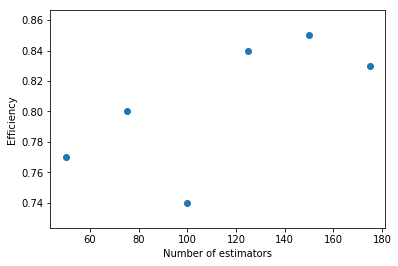

In [71]:
predicted_adaboost = quassify_adaboost(np.arange(50,200,25))

(array([  943.,   249.,   372.,   281.,  1054.,  1101.,     0.]),
 array([ 0.        ,  0.85714286,  1.71428571,  2.57142857,  3.42857143,
         4.28571429,  5.14285714,  6.        ]),
 <a list of 7 Patch objects>)

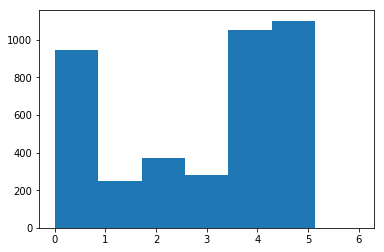

In [72]:
plt.hist(predicted_adaboost,range=(0,6),bins=7)

In [74]:
qso_result = encoder.inverse_transform(predicted_adaboost)

In [75]:
table_results = Table([Table(hdus[0][4].data)['TARGETID'],Table(hdus[0][4].data)['MAG'],qso_result],names=('TARGETID','MAG','OBJTYPE'))

In [76]:
table_results.write('./fake_qso/quassifier_results_adaboost_0.0.3.fits.gz', overwrite=True)

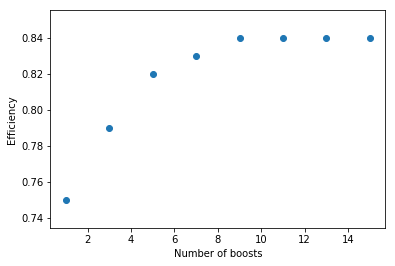

In [77]:
predicted_forest = quassify_forest(np.arange(1,16,2))

In [78]:
qso_result = encoder.inverse_transform(predicted_forest)

In [79]:
table_results = Table([Table(hdus[0][4].data)['TARGETID'],Table(hdus[0][4].data)['MAG'],qso_result],names=('TARGETID','MAG','OBJTYPE'))

In [80]:
table_results.write('./fake_qso/quassifier_results_forest_0.0.3.fits.gz', overwrite=True)

## Testing results

In [27]:
def test_results(results_table_path,truth_table_path,picname):
    results_table = Table.read(results_table_path)
    truth_table = Table.read(truth_table_path)
    joint_table = join(results_table,truth_table,'TARGETID')
    zarr= truth_table['Z']
    mask = [np.logical_and(truth_table['MAG'][:,2]>=22.0+0.7*i/5.,truth_table['MAG'][:,2]<22+0.7*(i+1)/5.) for i in range(0,5)]
    mask_redshift = [np.logical_and(zarr>2.1+0.2*i,zarr<2.1+0.2*(i+1)) for i in range(0,7)]
    mags = np.array([22+0.7*(i+0.5)/5. for i in range(0,5)])
    zs = np.array([2.1+0.2*(i+0.5) for i in range(0,7)])
    rqso= np.zeros(len(mask))
    relg= np.zeros(len(mask))
    rgal= np.zeros(len(mask))
    rstar=np.zeros(len(mask))
    rqsol=np.zeros(len(mask))
    rqsoz= np.zeros(len(mask_redshift))
    relgz= np.zeros(len(mask_redshift))
    rgalz= np.zeros(len(mask_redshift))
    rstarz=np.zeros(len(mask_redshift))
    rqsolz=np.zeros(len(mask_redshift))
    for imask,m in enumerate(mask):
        d_hzqso1 = np.logical_and(m,joint_table['OBJTYPE']=='HZ_QSO_1')
        d_hzqso2 = np.logical_and(m,joint_table['OBJTYPE']=='HZ_QSO_2')
        d_hzqso3 = np.logical_and(m,joint_table['OBJTYPE']=='HZ_QSO_3')
        d_qso = np.logical_and(m,joint_table['OBJTYPE']=='QSO')
        d_star = np.logical_and(m,joint_table['OBJTYPE']=='STAR')
        d_gal = np.logical_and(m,joint_table['OBJTYPE']=='GALAXY')
        d_elg = np.logical_and(m,joint_table['OBJTYPE']=='ELG')
        t_hzqso = np.logical_and(m,joint_table['TRUE_OBJTYPE']=='HZQSO')
        t_qso = np.logical_and(m,joint_table['TRUE_OBJTYPE']=='QSO')
        t_star = np.logical_and(m,joint_table['TRUE_OBJTYPE']=='STAR')
        t_elg = np.logical_and(m,joint_table['TRUE_OBJTYPE']=='ELG')
        t_gal = np.logical_and(m,joint_table['TRUE_OBJTYPE']=='GAL')
        qso_as_elg = np.logical_and(t_hzqso,d_elg)
        qso_as_qso = np.logical_and(t_hzqso,d_hzqso)
        qso_as_gal = np.logical_and(t_hzqso,d_gal)
        qso_as_star = np.logical_and(t_hzqso,d_star)
        qso_as_qsol = np.logical_and(t_hzqso,d_qso)
        rqso[imask] = np.count_nonzero(qso_as_qso)/(1.0*np.count_nonzero(t_hzqso))
        relg[imask] = np.count_nonzero(qso_as_elg)/(1.0*np.count_nonzero(t_hzqso))
        rgal[imask] = np.count_nonzero(qso_as_gal)/(1.0*np.count_nonzero(t_hzqso))
        rstar[imask] = np.count_nonzero(qso_as_star)/(1.0*np.count_nonzero(t_hzqso))
        rqsol[imask] = np.count_nonzero(qso_as_qsol)/(1.0*np.count_nonzero(t_hzqso))
    for iz,mz in enumerate(mask_redshift):
        d_hzqso1 = np.logical_and(mz,joint_table['OBJTYPE']=='HZ_QSO_1')
        d_qso = np.logical_and(mz,joint_table['OBJTYPE']=='QSO')
        d_star = np.logical_and(mz,joint_table['OBJTYPE']=='STAR')
        d_gal = np.logical_and(mz,joint_table['OBJTYPE']=='GALAXY')
        d_elg = np.logical_and(mz,joint_table['OBJTYPE']=='ELG')
        t_hzqso = np.logical_and(mz,joint_table['TRUE_OBJTYPE']=='HZQSO')
        t_qso = np.logical_and(mz,joint_table['TRUE_OBJTYPE']=='QSO')
        t_star = np.logical_and(mz,joint_table['TRUE_OBJTYPE']=='STAR')
        t_elg = np.logical_and(mz,joint_table['TRUE_OBJTYPE']=='ELG')
        t_gal = np.logical_and(mz,joint_table['TRUE_OBJTYPE']=='GAL')
        qso_as_elg = np.logical_and(t_hzqso,d_elg)
        qso_as_qso = np.logical_and(t_hzqso,d_hzqso1)
        qso_as_gal = np.logical_and(t_hzqso,d_gal)
        qso_as_star = np.logical_and(t_hzqso,d_star)
        qso_as_qsol = np.logical_and(t_hzqso,d_qso)
        print (1.0*np.count_nonzero(t_hzqso)), np.count_nonzero(d_hzqso1)
        rqsoz[iz] = np.count_nonzero(qso_as_qso)/(1.0*np.count_nonzero(t_hzqso))
        relgz[iz] = np.count_nonzero(qso_as_elg)/(1.0*np.count_nonzero(t_hzqso))
        rgalz[iz] = np.count_nonzero(qso_as_gal)/(1.0*np.count_nonzero(t_hzqso))
        rstarz[iz] = np.count_nonzero(qso_as_star)/(1.0*np.count_nonzero(t_hzqso))
        rqsolz[iz] = np.count_nonzero(qso_as_qsol)/(1.0*np.count_nonzero(t_hzqso))
    plt.figure()
    plt.plot(mags,rqso,'o',label='HZ-QSO as HZ-QSO')
    plt.plot(mags,relg+rgal,'x',markerfacecolor='none',label='HZ-QSO as GALAXY')
    plt.plot(mags,rstar,'+',markerfacecolor='none',label='HZ-QSO as STAR')
    plt.plot(mags,rqsol,'*',label='HZ-QSO as LZ-QSO')
    plt.plot(mags,np.ones_like(mags),'k--')
    plt.legend(loc='best')
    plt.xlabel('r-band magnitude')
    plt.ylabel('Fraction detected')
    #plt.ylim(-0.05,1.05)
    savefig('./fake_qso/efficiency_mag_'+picname+'.png')
    plt.figure()
    plt.plot(zs,rqsoz,'o',label='HZ-QSO as HZ-QSO')
    plt.plot(zs,relgz+rgalz,'x',markerfacecolor='none',label='HZ-QSO as GALAXY')
    plt.plot(zs,rstarz,'+',markerfacecolor='none',label='HZ-QSO as STAR')
    plt.plot(zs,rqsolz,'*',label='HZ-QSO as LZ-QSO')
    plt.legend(loc='best')
    plt.plot(zs,np.ones_like(zs),'k--')
    plt.xlabel('Redshift')
    plt.ylabel('Fraction detected')
    #plt.ylim(-0.05,1.05)
    savefig('./fake_qso/efficiency_z_'+picname+'.png')

# KNN classifier

In [81]:
def quassifier_knn(kn):
    from sklearn.neighbors import KNeighborsClassifier
    efficiency = np.zeros(len(kn))
    purity = np.zeros(len(kn))
    i_best = 0
    qso_fit_best = None

    for i, knn in enumerate(kn):
        knc = KNeighborsClassifier(n_neighbors=knn)
        knc.fit(qso_flux_train, qso_class_train)

        qso_fit_train = knc.predict(qso_flux_train)
        qso_fit = knc.predict(qso_flux_test)
        good = np.count_nonzero(qso_fit==qso_class_test)/(1.0*len(qso_class_test))
        efficiency[i]=good
        if(good>qso_fit_best):
            qso_fit_best = good
            i_best = i
    plt.scatter(kn,efficiency)
    plt.xlabel('Number of neighbors')
    plt.ylabel('Efficiency')
    knc = KNeighborsClassifier(n_neighbors=kn[i_best])
    knc.fit(qso_flux_train,qso_class_train)
    results = knc.predict(xvec)
    return results

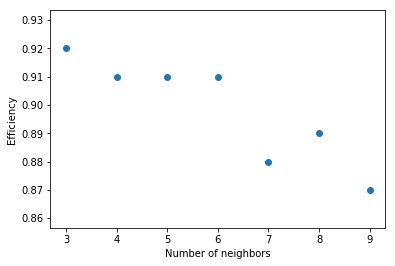

In [82]:
qso_knn = quassifier_knn(np.arange(3,10))

In [83]:
qso_result = encoder.inverse_transform(qso_knn)

In [84]:
table_results = Table([Table(hdus[0][4].data)['TARGETID'],Table(hdus[0][4].data)['MAG'],qso_result],names=('TARGETID','MAG','OBJTYPE'))

In [85]:
table_results.write('./fake_qso/quassifier_results_knn_0.0.3.fits.gz', overwrite=True)

# Dense layers Neural Network (this is the one that works the best)

In [88]:
def quassify_dense():
    model = Sequential()
    model.add(Dense(128, input_dim=qso_flux.shape[1]+2, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(24, init='normal', activation='relu'))
    #model.add(Dense(8, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(qso_flux_train, dummy_y[0:ntrain], batch_size=ntrain, nb_epoch=1000, verbose=0, validation_split=0.2)
    return model

In [89]:
model = quassify_dense()

In [91]:
predicted_output = model.predict_on_batch(xvec)
qso_result = encoder.inverse_transform(np_utils.categorical_probas_to_classes(predicted_output))

4000


In [93]:
table_results = Table([Table(hdus[0][4].data)['TARGETID'],Table(hdus[0][4].data)['MAG'],predicted_output],names=('TARGETID','MAG','Prob'))

In [94]:
table_results.write('./fake_qso/quassifier_results_dense_prob_03032017.fits.gz', overwrite=True)

In [95]:
results = encoder.inverse_transform(np_utils.categorical_probas_to_classes(predicted_output))
gals = results=='GALAXY'
print np.count_nonzero(gals)

1017
